# Tomorrow.io Weather Data Analysis

This notebook visualizes weather data collected from the Tomorrow.io API for 10 geolocations.

In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from sqlalchemy import create_engine
from dotenv import load_dotenv

load_dotenv()

db_url = f"postgresql://{os.getenv('PGUSER', 'postgres')}:{os.getenv('PGPASSWORD', 'postgres')}@{os.getenv('PGHOST', 'localhost')}:{os.getenv('PGPORT', '5432')}/{os.getenv('PGDATABASE', 'tomorrow')}"
engine = create_engine(db_url)
print(f"Connected to database: {os.getenv('PGDATABASE', 'tomorrow')}")

Connected to database: tomorrow


## Query 1: Latest Temperature and Wind Speed by Location

What's the latest temperature for each geolocation? What's the latest wind speed?

In [2]:
# Latest temperature and wind speed for each location
latest_query = """
SELECT DISTINCT ON (l.id)
    l.id as location_id,
    l.lat,
    l.lon,
    w.timestamp,
    w.temperature,
    w.wind_speed
FROM locations l
LEFT JOIN weather_data w ON l.id = w.location_id
WHERE l.is_active = TRUE
ORDER BY l.id, w.timestamp DESC NULLS LAST
"""

latest_df = pd.read_sql(latest_query, engine)
latest_df

,location_id,lat,lon,timestamp,temperature,wind_speed
0,1,25.86,-97.42,2024-06-01 19:00:00+00:00,None,None
1,2,25.90,-97.52,NaT,None,None
2,3,25.90,-97.48,NaT,None,None
3,4,25.90,-97.44,NaT,None,None
4,5,25.90,-97.40,NaT,None,None
5,6,25.92,-97.38,NaT,None,None
6,7,25.94,-97.54,NaT,None,None
7,8,25.94,-97.52,NaT,None,None
8,9,25.94,-97.48,NaT,None,None
9,10,25.94,-97.44,NaT,None,None


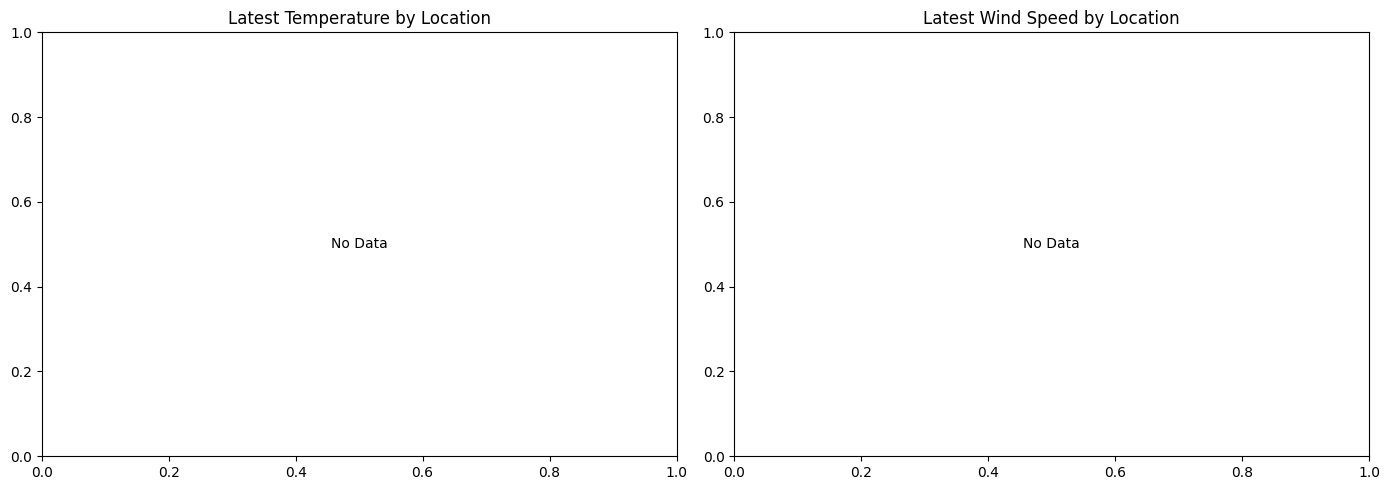

In [3]:
# Visualize latest temperature and wind speed
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Temperature
temp_df = latest_df.dropna(subset=['temperature'])
if not temp_df.empty:
    ax1.bar(range(len(temp_df)), temp_df['temperature'], color='coral')
    ax1.set_xticks(range(len(temp_df)))
    ax1.set_xticklabels([f"({r['lat']}, {r['lon']})" for _, r in temp_df.iterrows()], rotation=45, ha='right')
    ax1.set_ylabel('Temperature (°C)')
else:
    ax1.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax1.transAxes)
ax1.set_title('Latest Temperature by Location')

# Wind Speed
wind_df = latest_df.dropna(subset=['wind_speed'])
if not wind_df.empty:
    ax2.bar(range(len(wind_df)), wind_df['wind_speed'], color='skyblue')
    ax2.set_xticks(range(len(wind_df)))
    ax2.set_xticklabels([f"({r['lat']}, {r['lon']})" for _, r in wind_df.iterrows()], rotation=45, ha='right')
    ax2.set_ylabel('Wind Speed (m/s)')
else:
    ax2.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=ax2.transAxes)
ax2.set_title('Latest Wind Speed by Location')

plt.tight_layout()
plt.show()

## Query 2: Hourly Time Series (-1 day to +5 days)

Show an hourly time series of temperature from a day ago to 5 days in the future for a selected location.

In [4]:
# Select location (change location_id to view different locations)
location_id = 1

# Time range: -1 day to +5 days
start_time = datetime.now() - timedelta(days=1)
end_time = datetime.now() + timedelta(days=5)

time_series_query = """
SELECT 
    w.timestamp,
    w.temperature,
    l.lat,
    l.lon
FROM weather_data w
JOIN locations l ON w.location_id = l.id
WHERE w.location_id = %(location_id)s
  AND w.data_granularity = 'hourly'
  AND w.timestamp BETWEEN %(start)s AND %(end)s
ORDER BY w.timestamp
"""

ts_df = pd.read_sql(time_series_query, engine, params={'location_id': location_id, 'start': start_time, 'end': end_time})
ts_df['timestamp'] = pd.to_datetime(ts_df['timestamp'])

print(f"Location: ({ts_df['lat'].iloc[0] if len(ts_df) > 0 else 'N/A'}, {ts_df['lon'].iloc[0] if len(ts_df) > 0 else 'N/A'})")
print(f"Records: {len(ts_df)}")
ts_df.head()

Location: (N/A, N/A)
Records: 0


,timestamp,temperature,lat,lon


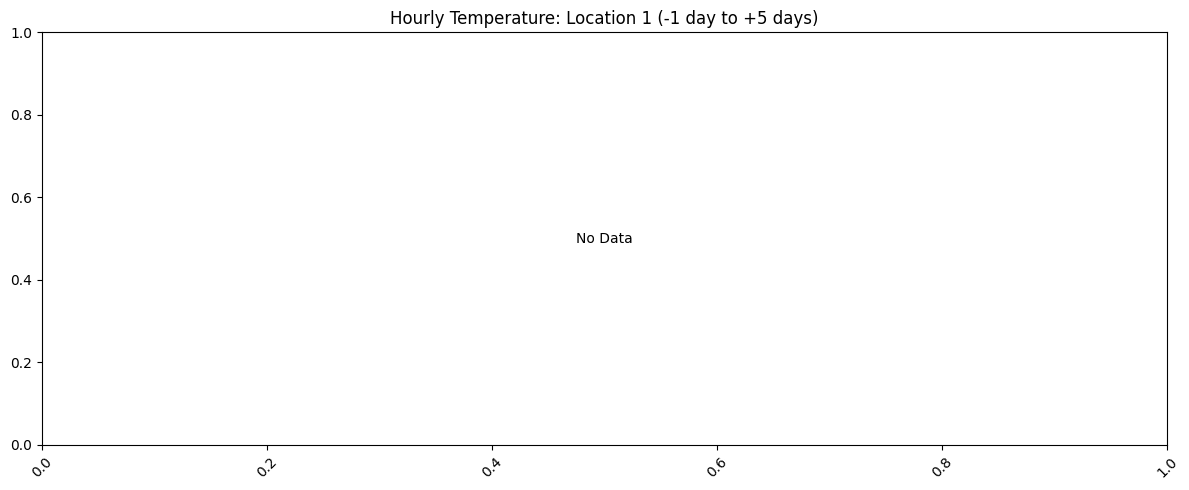

In [5]:
# Plot hourly temperature time series
plt.figure(figsize=(12, 5))

if not ts_df.empty and ts_df['temperature'].notna().any():
    plt.plot(ts_df['timestamp'], ts_df['temperature'], marker='o', markersize=3, color='coral')
    plt.axvline(datetime.now(), color='gray', linestyle='--', label='Now')
    plt.xlabel('Time')
    plt.ylabel('Temperature (°C)')
    plt.legend()
else:
    plt.text(0.5, 0.5, 'No Data', ha='center', va='center', transform=plt.gca().transAxes)

plt.title(f'Hourly Temperature: Location {location_id} (-1 day to +5 days)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()